In [ ]:
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer, pipeline
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split, StratifiedKFold
import tensorflow as tf
import pandas as pd
from sklearn.utils import class_weight
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.utils import plot_model


# Model Kurulumu


In [ ]:
model = TFAutoModelForSequenceClassification.from_pretrained("VRLLab/TurkishBERTweet", num_labels=3, from_pt=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("VRLLab/TurkishBERTweet")

In [ ]:
model.summary()

Model: "tf_roberta_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLaye  multiple                  162251520 
 r)                                                              
                                                                 
 classifier (TFRobertaClass  multiple                  592899    
 ificationHead)                                                  
                                                                 
Total params: 162844419 (621.20 MB)
Trainable params: 162844419 (621.20 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
plot_model(tf_roberta_for_sequence_classification_1, to_file='model_visualization.png', show_shapes=True, show_layer_names=True)

# Labeled data eğitimi

In [ ]:
file_path2 = '/content/Balanced_Sample_Sentiment_Dataset.csv'
df_labeled = pd.read_csv(file_path2)

In [ ]:
df_labeled.head()

,index_1,index_2,sentiment,content
0,42596,42596.0,1,doların 18 liraya çıktığı gün bu gamepass de p...
1,45679,45679.0,2,arkadaşlar taş gibi makina ama saç traşı için ...
2,52020,52020.0,0,ilk dususte beyni gitti
3,66016,66556.0,2,Ürünü deneme imkanım olmadı ama dün gece verdi...
4,27661,27661.0,1,çagri merkezi ölmüş sanirim gecen hafta 35 mbi...


In [ ]:
df_labeled.rename(columns={'Content': 'content','Sentiment':'sentiment'}, inplace=True)

df_labeled['sentiment'] = pd.to_numeric(df_labeled['sentiment'], errors='coerce')  # Hatalı verileri NaN olarak işliyoruz

df_labeled = df_labeled.drop(columns=['index_1','index_2'])

# NaN değerleri temizliyoruz
df_labeled = df_labeled.dropna()
df_labeled['sentiment'] = df_labeled['sentiment'].apply(lambda x: 0 if x == 19.9 or x == 24.0 else x)
print(f"Etiketlerin aralığı: {df_labeled['sentiment'].min()} - {df_labeled['sentiment'].max()}")

Etiketlerin aralığı: 0 - 2


In [ ]:
df_labeled.head()

,sentiment,content
0,1,doların 18 liraya çıktığı gün bu gamepass de p...
1,2,arkadaşlar taş gibi makina ama saç traşı için ...
2,0,ilk dususte beyni gitti
3,2,Ürünü deneme imkanım olmadı ama dün gece verdi...
4,1,çagri merkezi ölmüş sanirim gecen hafta 35 mbi...


In [ ]:
df_labeled['sentiment'].value_counts()

,count
sentiment,
1,3333
2,3333
0,3333


In [ ]:
df_labeled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  9999 non-null   int64 
 1   content    9999 non-null   object
dtypes: int64(1), object(1)
memory usage: 156.4+ KB


In [ ]:
df_labeled.isnull().sum()

,0
sentiment,0
content,0


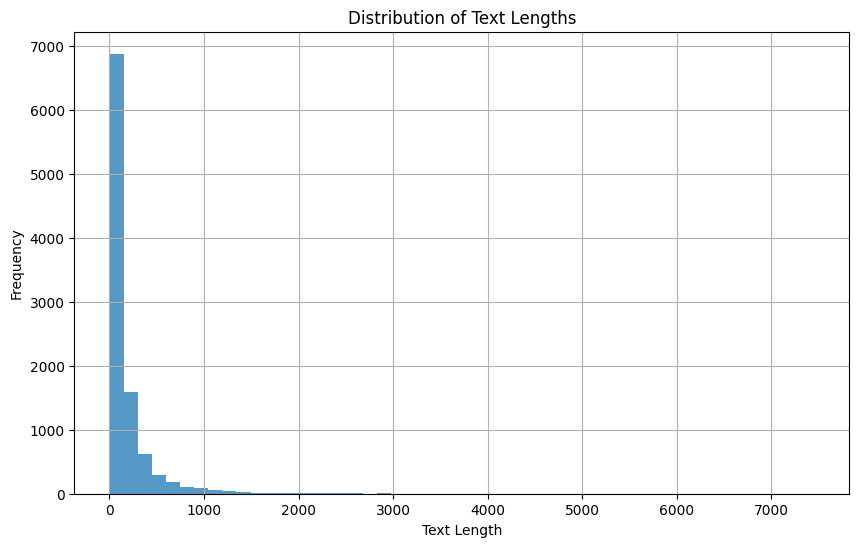

184.23772377237725

In [ ]:
import matplotlib.pyplot as plt

# text uzunluklarını hesaplıyoruz
df_labeled['Text_Length'] = df_labeled['content'].apply(len)

# dağılımları grafikleştiriyoruz
plt.figure(figsize=(10, 6))
plt.hist(df_labeled['Text_Length'], bins=50, alpha=0.75)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# ortama text uzunluğu
average_text_length = df_labeled['Text_Length'].mean()
average_text_length

In [ ]:
sentences = df_labeled.content.values
max_len = 128 #ortalama text uzunluğuna göre

In [ ]:
def tokenize_function(texts):
    encoded = tokenizer(
        list(texts),  # inputların olduğu arrayi string listesine çevirdik
        padding='max_length',
        truncation=True,
        max_length=max_len,
        return_tensors="tf",
        return_attention_mask=True
    )
    return {
        'input_ids': encoded['input_ids'],
        'attention_mask': encoded['attention_mask']
    }


In [ ]:
# Verisetini %70 eğitim ve %30 doğrulama olarak ayır
train, val = train_test_split(df_labeled, test_size=0.30, stratify=df_labeled['sentiment'], random_state=42)

print("Training set size:", len(train))
print("Validation set size:", len(val))

Training set size: 6999
Validation set size: 3000


In [ ]:
# TensorFlow datasetlerini oluşturuyoruz
def create_dataset(df):
    encodings = tokenize_function(df['content'].values)
    return tf.data.Dataset.from_tensor_slices((
        {
            'input_ids': encodings['input_ids'],
            'attention_mask': encodings['attention_mask']
        },
        df['sentiment'].values
    ))
train_dataset = create_dataset(train)
val_dataset = create_dataset(val)

In [ ]:
batch_size = 16;

In [ ]:
# Calculate class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train['sentiment']), y=train['sentiment'])
class_weights = dict(enumerate(class_weights))

In [ ]:
# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  # Less aggressive reduction
    patience=2, # Reduce learning rate after 2 epochs of no improvement
    min_lr=1e-7
)



In [ ]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=3e-5,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-8
)

In [ ]:
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

history = model.fit(
    train_dataset.batch(batch_size),
    validation_data=val_dataset.batch(batch_size),
    epochs=20,
    #class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr],
)


Epoch 1/20
438/438 [==============================] - 2331s 5s/step - loss: 0.4982 - accuracy: 0.8201 - val_loss: 0.3446 - val_accuracy: 0.8753 - lr: 3.0000e-05
Epoch 2/20
  4/438 [..............................] - ETA: 33:09 - loss: 0.2792 - accuracy: 0.9219

In [ ]:
# Eğitim ve doğrulama kaybı
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Eğitim ve doğrulama doğruluğu
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.savefig('training_and_validation_metrics.png')

plt.show()

# TEST


In [ ]:
# Load test data
test_file_path = '/content/Unlabeled_Sentiment_Dataset.csv'
test_df = pd.read_csv(test_file_path)

In [ ]:
test_df.head()

,Unnamed: 0,content
0,9999,ücretsiz nasıl daha çok kitlelere insanlara ul...
1,10000,baskalarinin hayatlarina burnumuzu sokmadigimi...
2,10001,sevmediğim klasik sosyal medya uygulamalarında...
3,10002,farklı şehirlerden arkadaşlarımla üniversite y...
4,10003,falanca kullanıcının canlı yayın bildirimlerin...


In [ ]:
test_df.rename(columns={'Content': 'content'}, inplace=True)

test_df = test_df.drop(columns=['Unnamed: 0'])

# NaN değerleri temizleyin
test_df = test_df.dropna()

In [ ]:
# Tokenize the test data
test_encodings = tokenize_function(test_df['content'].values)

# Create a TensorFlow dataset
test_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': test_encodings['input_ids'],
        'attention_mask': test_encodings['attention_mask']
    }
))

In [ ]:
# Make predictions
predictions = model.predict(test_dataset.batch(16))

# Get the predicted class (assuming 3 classes: 0, 1, 2)
predicted_classes = tf.argmax(predictions.logits, axis=1).numpy()

# Get the confidence scores
confidence_scores = tf.nn.softmax(predictions.logits, axis=1).numpy()

2522/2522 [==============================] - 68s 27ms/step


In [ ]:
# eğer confidence score >= 0.80 olsun istiyorsan bunu çalıştır
high_confidence_mask = (confidence_scores.max(axis=1) >= 0.80)
filtered_predicted_classes = predicted_classes[high_confidence_mask]
filtered_confidence_scores = confidence_scores[high_confidence_mask]
filtered_content = test_df['content'].values[high_confidence_mask]

In [ ]:
# Create a new DataFrame with the filtered predictions
data = [(content, pred, score) for content, pred, score in zip(filtered_content, filtered_predicted_classes, filtered_confidence_scores)]
filtered_df = pd.DataFrame(data, columns=['content', 'predicted_sentiment', 'confidence_score'])

In [ ]:
# eğer filtreleme yapmayacaksan bunu çalıştır
predictions_df = pd.DataFrame({
    'content': filtered_df['content'],
    'predicted_sentiment': predicted_classes,
    'confidence_score': confidence_scores.max(axis=1)
})

In [ ]:
filtered_df.head()

,content,predicted_sentiment,confidence_score
0,ücretsiz nasıl daha çok kitlelere insanlara ul...,1,"[0.00095694966, 0.9983553, 0.0006876121]"
1,baskalarinin hayatlarina burnumuzu sokmadigimi...,1,"[0.00072242337, 0.9982957, 0.000981914]"
2,sevmediğim klasik sosyal medya uygulamalarında...,1,"[0.000959021, 0.998357, 0.00068400364]"
3,farklı şehirlerden arkadaşlarımla üniversite y...,1,"[0.0008056566, 0.99777114, 0.001423225]"
4,falanca kullanıcının canlı yayın bildirimlerin...,1,"[0.00087387307, 0.99837375, 0.00075226027]"


In [ ]:
# Save predictions to CSV
output_file_path = '/content/high_confidence_predictions.csv'
filtered_df.to_csv(output_file_path, index=False)

# SAMPLE DATASET + PREDICTIONS TEST

In [ ]:
# Merge the datasets
merged_df = pd.merge(df_labeled, filtered_df, on='content', how='inner')

# If you want to keep all rows from the original dataset, use left join instead:
# merged_df = pd.merge(original_df, predictions_df, on='Content', how='left')

# Save the merged dataset
output_file_path = '/content/merged_dataset.csv'
merged_df.to_csv(output_file_path, index=False)


In [ ]:
merged_df.head(100)

,content,sentiment
0,doların 18 liraya çıktığı gün bu gamepass de p...,1
1,arkadaşlar taş gibi makina ama saç traşı için ...,2
2,ilk dususte beyni gitti,0
3,Ürünü deneme imkanım olmadı ama dün gece verdi...,2
4,çagri merkezi ölmüş sanirim gecen hafta 35 mbi...,1
...,...,...
95,Müşteri hizmetleri sorularımı hızlıca yanıtlad...,1
96,Müşteri hizmetleri sorularımı hızlıca yanıtlad...,1
97,Müşteri hizmetleri sorularımı hızlıca yanıtlad...,1
98,Müşteri hizmetleri sorularımı hızlıca yanıtlad...,1


In [ ]:
merged_df['sentiment'].isnull().sum()

0

In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11757 entries, 0 to 11756
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   sentiment            11757 non-null  int64 
 1   content              11757 non-null  object
 2   Text_Length          11757 non-null  int64 
 3   predicted_sentiment  11757 non-null  int64 
 4   confidence_score     11757 non-null  object
dtypes: int64(3), object(2)
memory usage: 459.4+ KB


In [ ]:
merged_df = merged_df.drop(columns=['sentiment','Text_Length','confidence_score'])

merged_df.rename(columns={'Content': 'content','predicted_sentiment':'sentiment'}, inplace=True)


# NaN değerleri temizliyoruz
df_labeled = df_labeled.dropna()
df_labeled['sentiment'] = df_labeled['sentiment'].apply(lambda x: 0 if x == 19.9 or x == 24.0 else x)
print(f"Etiketlerin aralığı: {df_labeled['sentiment'].min()} - {df_labeled['sentiment'].max()}")

Etiketlerin aralığı: 0 - 2


In [ ]:
# Tokenize the test data
test_encodings = tokenize_function(merged_df['content'].values)

# Create a TensorFlow dataset
test_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': test_encodings['input_ids'],
        'attention_mask': test_encodings['attention_mask']
    }
))

In [ ]:
# Make predictions
predictions = model.predict(test_dataset.batch(16))

# Get the predicted class (assuming 3 classes: 0, 1, 2)
predicted_classes = tf.argmax(predictions.logits, axis=1).numpy()

# Get the confidence scores
confidence_scores = tf.nn.softmax(predictions.logits, axis=1).numpy()

735/735 [==============================] - 20s 27ms/step


In [ ]:
# Create a new DataFrame with the predictions
predictions_df = pd.DataFrame({
    'text': merged_df['content'],
    'predicted_sentiment': predicted_classes,
    'confidence_score': confidence_scores.max(axis=1)
})

In [ ]:
predictions_df.head()

,text,predicted_sentiment,confidence_score
0,doların 18 liraya çıktığı gün bu gamepass de p...,1,0.998317
1,arkadaşlar taş gibi makina ama saç traşı için ...,2,0.983468
2,ilk dususte beyni gitti,0,0.998452
3,Ürünü deneme imkanım olmadı ama dün gece verdi...,2,0.997096
4,çagri merkezi ölmüş sanirim gecen hafta 35 mbi...,1,0.998301


In [ ]:
predictions_df.tail()

,text,predicted_sentiment,confidence_score
11752,Çocukların odasına almıştım ama ışığı çok yete...,0,0.991473
11753,aylık 210 ödeyerek 3 sene sonraki sürenin sonu...,1,0.998320
11754,yakın zamanda portre modu gelecekmiş,1,0.998385
11755,ürünün paketlemesi iyi değildi ayrıca ürün çok...,0,0.997631
11756,Fiyatı göz önünde bulundurulursa başarılı Anca...,2,0.997457


In [ ]:
predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11757 entries, 0 to 11756
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   text                 11757 non-null  object 
 1   predicted_sentiment  11757 non-null  int64  
 2   confidence_score     11757 non-null  float32
dtypes: float32(1), int64(1), object(1)
memory usage: 229.8+ KB


In [ ]:
# hem pseudo labelların oldugu hem initial verilerin oldugu son veriseti
output_file_path = '/content/predictions.csv'
predictions_df.to_csv(output_file_path, index=False)